In [29]:
import torch
import torch.nn as nn
import torch.functional as F

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from options import Options
from models import *
from dataset import *
from utils import *

In [30]:
import os
# try:
#     os.chdir('workspace')
# except:
#     pass

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [32]:
os.listdir('models')

['BERTCombinedModel_Test_finetune', 'BERTSeperateModel_Test', 'LSTM_Test']

In [33]:
# Change this
model_folder = f"models/BERTSeperateModel_Test/"

In [34]:
opt = Options()
opt.load_options(model_folder)

state = torch.load(f"{model_folder}/latest.pth")
history = torch.load(f"{model_folder}/history.pth")

Dataset = Datasets[opt.dataset]
model = Models[opt.model](opt).to(device)

test_df = pd.read_csv(f"{opt.data_folder}/test.csv")
test_set = Dataset(test_df, opt)
test_loader = DataLoader(test_set, batch_size=30, shuffle=True)

model.load_state_dict(state['state_dict'])

Using cache found in C:\Users\statix/.cache\torch\hub\huggingface_pytorch-transformers_main
Using cache found in C:\Users\statix/.cache\torch\hub\huggingface_pytorch-transformers_main


<All keys matched successfully>

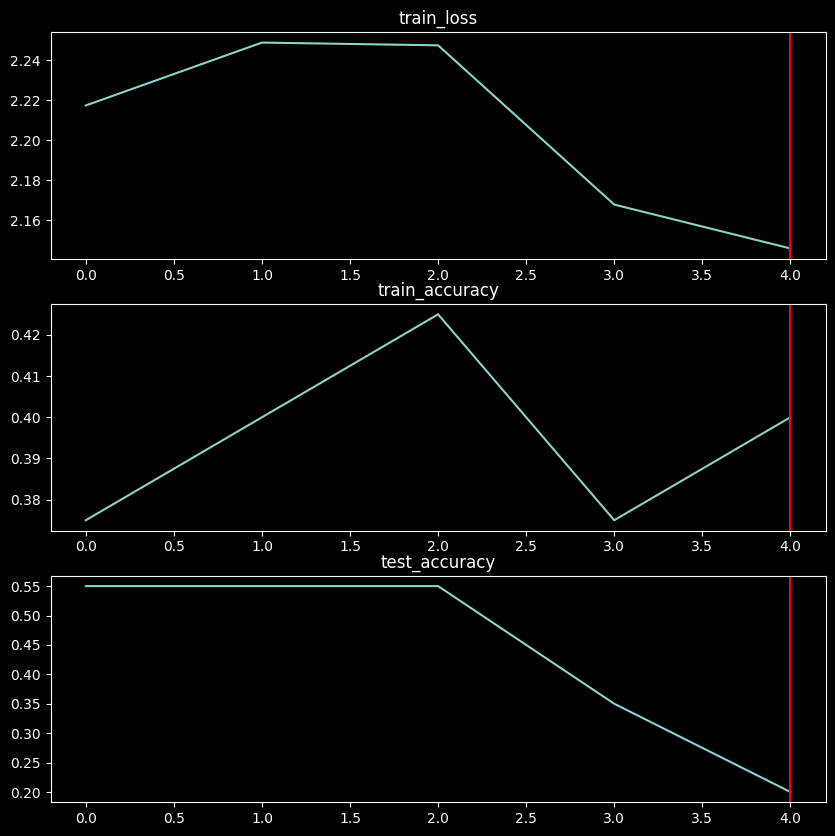

In [35]:
# model = model.to(device)
fig, axs = plt.subplots(len(history),1,figsize=(10,10))
test_best = state['epoch']

for i, key in enumerate(history.keys()):
    ax = axs[i]
    ax.set_title(key)

    ax.plot(history[key])
    ax.axvline(test_best, color='red')

In [36]:
# Confusion matrix and accuracies

test_loader = DataLoader(test_set, batch_size=30, shuffle=True)


y_pred, y_test, test_accuracy = predict(model, test_loader)
print(test_accuracy)

0.2


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.38      0.27      0.32        11
           2       0.08      0.25      0.12         4

    accuracy                           0.20        20
   macro avg       0.15      0.17      0.15        20
weighted avg       0.22      0.20      0.20        20



c:\Users\statix\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\statix\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\statix\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


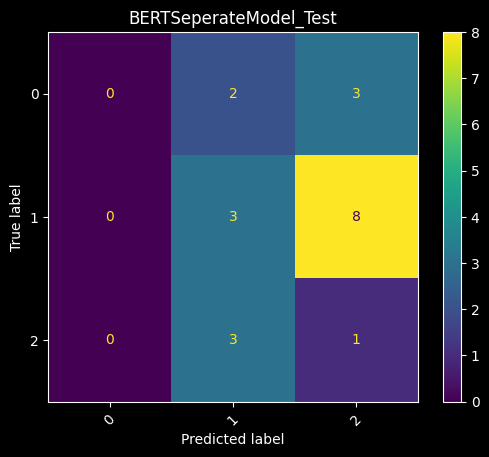

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation = 45)
plt.title(f"{model_folder.split('/')[1]}")
print(classification_report(y_test, y_pred))